In [1]:
## Import necessary modules 

from astropy.io import fits
from astropy.wcs import WCS
from astropy.stats import sigma_clipped_stats
import glob
import os
import subprocess
import warnings
import numpy as np
import matplotlib.pyplot as plt
import photutils
import pyregion

# You can ignore any warnings that appear below, but if any modules can't be imported you need to install them

In [2]:
## Define data directories

curpath = os.path.abspath('.')                   # top level directory
dataFolder = os.path.join(curpath, 'data')        # data directory
biasFolder = os.path.join(dataFolder, 'bias')     # bias frames subdirectory
flatFolder = os.path.join(dataFolder, 'flat')     # flat fields subdirectory
sciFolder = os.path.join(dataFolder, 'science')   # science data subdirectory
procFolder = os.path.join(curpath, 'processing')  # processing directory
if not os.path.isdir(procFolder): 
    os.mkdir(procFolder)
else:
    for f in os.listdir(procFolder):
        try:
            os.remove(os.path.join(procFolder,f)) # clear the processing folder from previous iterations
        except:
            print('Could not remove',f)

In [3]:
os.chdir(sciFolder)
fileList = sorted(glob.glob('*.fits'))
os.chdir(curpath)
biasList = sorted(glob.glob(os.path.join(biasFolder,'*.fits')))
flatList = sorted(glob.glob(os.path.join(flatFolder,'*.fits')))
sciList = [os.path.join(sciFolder, file) for file in fileList]
procList = [os.path.join(procFolder, file).replace('.fits','.proc.fits') for file in fileList]
print('Found',len(biasList),'bias files; ',len(flatList),'flat files; ',len(sciList),'science files')

Found 14 bias files;  8 flat files;  30 science files


In [4]:
warnings.filterwarnings("ignore")

In [5]:
## Open an example FITS file

exampleFile = sciList[0]         # The first science image
HDUList = fits.open(exampleFile) # Open the file
HDUList.info()                   # Print some information about the FITS file structure.  
## Print some header properties

header = HDUList[0].header # Get the header out of the HDU list.
print(repr(header[0:13]))  # Print the first 14 lines of the header (in raw format).
print(repr(header[24:34])) # Print some additional lines
print(repr(header[48:52])) 
print(repr(header[67:71])) 
print(repr(header[129:135])) 
print()
print('The object is:', header['OBJECT'])   # Print the name of the object being observed
# print('The filters are:', header['ACAMFILT']) # Print the names of the optical filters in the light path.
print('The exposure time is:', header['EXPTIME'])  # Print the exposure time

Filename: /Users/jigyasachouhan/Documents/Krittika/KSP/g_band/data/science/20230520151900-863-RA.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     133   (4096, 4108)   int16 (rescales to uint16)   
SIMPLE  =                    T / conform to FITS standard                       
BITPIX  =                   16 / unsigned short data                            
NAXIS   =                    2 / number of axes                                 
NAXIS1  =                 4096 / length of data axis                            
NAXIS2  =                 4108 / length of data axis                            
EXTEND  =                    T / this is FITS with extensions                   
HISTORY Created with RTS2 version 0.9.5 build on May 12 2020 19:07:30.          
CTIME   =           1684595940 / exposure start (seconds since 1.1.1970)        
USEC    =               863089 / exposure start micro seconds                   
JD      =     246008

In [6]:
## Bias subtract and flat-field all science frames and write out pre-processed files.

numSciFiles = len(sciList)
numBiasFiles = len(biasList)
numFlatFiles = len(flatList)
print('Found %d science files'%numSciFiles)
# print(sciList[0][-26:-18])
# print(biasList[0][-24:-16])
# print(flatList[0][-27:-19])
# HDUList = fits.open(sciList[0])
# print(HDUList[1].data)

for i in range(numSciFiles):
    
    # Read in the FITS data.
    HDUList = fits.open(sciList[i])
    primaryHeader = HDUList[0].header
    imageData = HDUList[0].data    
    HDUList.close()
    donefori = False

    for j in range(numBiasFiles):
        if biasList[j][-24:-16]==sciList[i][-26:-18]:
            HDUList = fits.open(biasList[j])
            biasHeader = HDUList[0].header
            masterBias = HDUList[0].data
            HDUList.close()

            for k in range(numFlatFiles):
                if flatList[k][-27:-19]==sciList[i][-26:-18]:
                    HDUList = fits.open(flatList[k])
                    flatHeader = HDUList[0].header
                    masterFlatFixed = HDUList[0].data
                    HDUList.close()
                    # print(masterFlatFixed)
                    masterFlatFixed[masterFlatFixed<0.2] = float('NaN')

    
                    # Correct for the bias and flats here
                    procData = (imageData - masterBias) / masterFlatFixed
    
                    # Prepare the output FITS structure in simple format
                    procHDU = fits.PrimaryHDU(procData)  # Create a new HDU with the processed image data
                    procHDU.header = primaryHeader       # Copy over the header from the raw file
                    procHDU.header.add_history('Bias corrected and flat-fielded') # Add a note to the header

                    # Write the reduced frame to disk
                    print(sciList[i],'->',procList[i])
                    procHDU.writeto(procList[i], overwrite=True)
                    donefori = True

            if not donefori:
                HDUList = fits.open(flatList[- 1])
                flatHeader = HDUList[0].header
                masterFlatFixed = HDUList[0].data
                HDUList.close()
                masterFlatFixed[masterFlatFixed<0.2] = float('NaN')

                # Correct for the bias and flats here
                procData = (imageData - masterBias) / masterFlatFixed

                # Prepare the output FITS structure in simple format
                procHDU = fits.PrimaryHDU(procData)  # Create a new HDU with the processed image data
                procHDU.header = primaryHeader       # Copy over the header from the raw file
                procHDU.header.add_history('Bias corrected and flat-fielded') # Add a note to the header

                # Write the reduced frame to disk
                print(sciList[i],'->',procList[i])
                procHDU.writeto(procList[i], overwrite=True)
                    
                
        

Found 30 science files
/Users/jigyasachouhan/Documents/Krittika/KSP/g_band/data/science/20230520151900-863-RA.fits -> /Users/jigyasachouhan/Documents/Krittika/KSP/g_band/processing/20230520151900-863-RA.proc.fits
/Users/jigyasachouhan/Documents/Krittika/KSP/g_band/data/science/20230521151417-752-RA.fits -> /Users/jigyasachouhan/Documents/Krittika/KSP/g_band/processing/20230521151417-752-RA.proc.fits
/Users/jigyasachouhan/Documents/Krittika/KSP/g_band/data/science/20230521154933-241-RA.fits -> /Users/jigyasachouhan/Documents/Krittika/KSP/g_band/processing/20230521154933-241-RA.proc.fits
/Users/jigyasachouhan/Documents/Krittika/KSP/g_band/data/science/20230522153045-729-RA.fits -> /Users/jigyasachouhan/Documents/Krittika/KSP/g_band/processing/20230522153045-729-RA.proc.fits
/Users/jigyasachouhan/Documents/Krittika/KSP/g_band/data/science/20230522154624-727-RA.fits -> /Users/jigyasachouhan/Documents/Krittika/KSP/g_band/processing/20230522154624-727-RA.proc.fits
/Users/jigyasachouhan/Docum

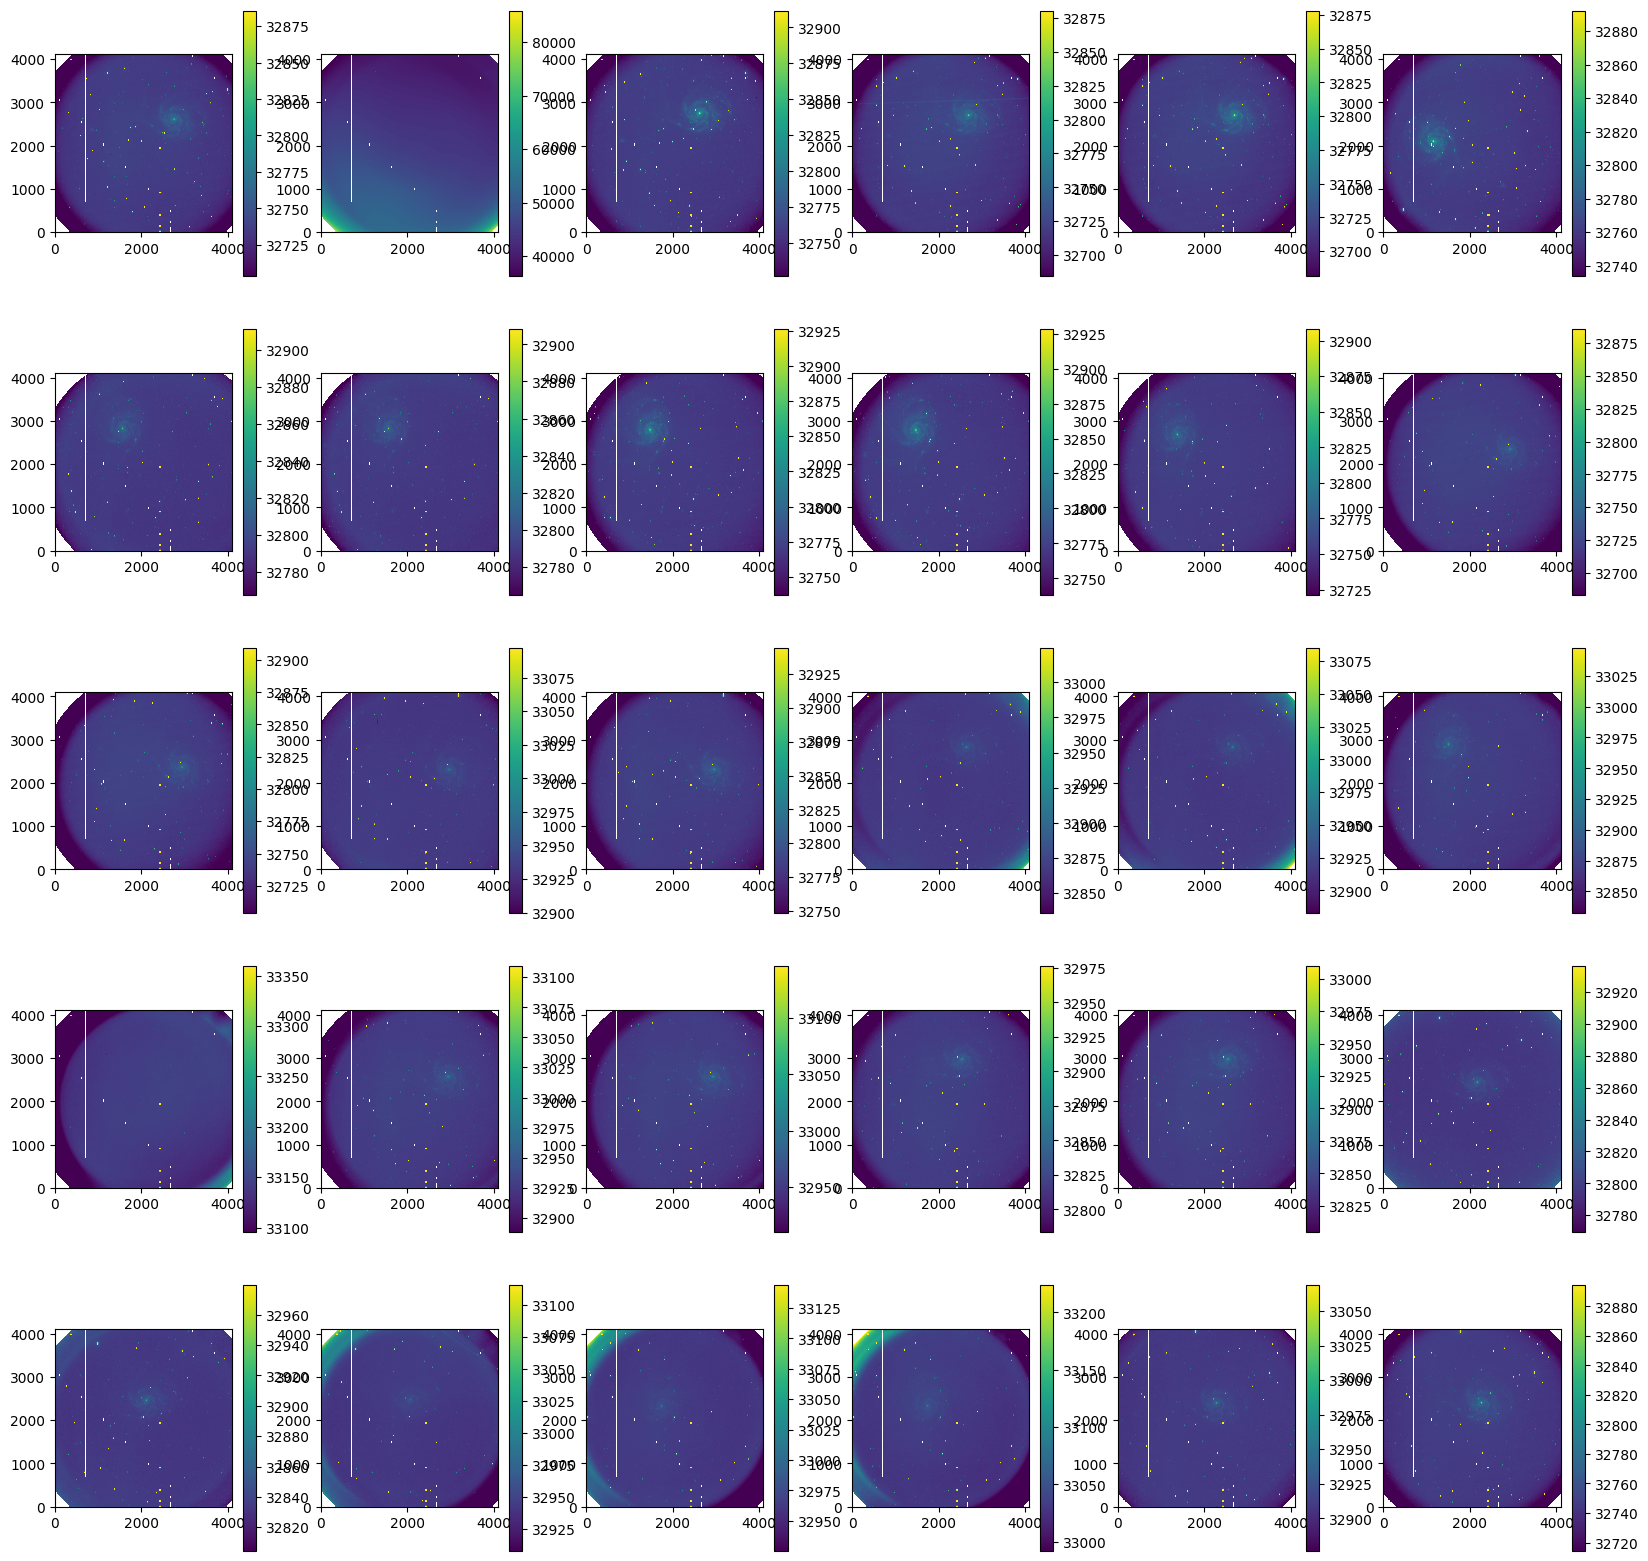

In [7]:
# Inspect the processed science files
numProcFiles = len(procList)
plt.figure(figsize=(20,20))
j = 1
for i in range(numProcFiles):
        if os.path.isfile(procList[i]):
            procHDU = fits.open(procList[i])
            procData = procHDU[0].data
            procHDU.close()
            
            mean, median, std = sigma_clipped_stats(procData)
            plt.subplot(5,6,j)
            j = j+1
            plt.imshow(procData, vmin = median - 2*std, vmax = median + 10*std, origin='lower')
            plt.colorbar()
        
